In [ ]:
pip install transformers==4.30

In [ ]:
!pip install -q transformers datasets
!pip install accelerate -U
!pip install transformers[torch]
!pip install umap-learn
!pip install -U imbalanced-learn
!pip3 install Cython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F


from umap import UMAP
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import datasets
from datasets import Dataset, DatasetDict
from datasets import load_dataset

from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer
from transformers import Trainer

# Load Dataset

In [ ]:
hf_dataset = load_dataset("dair-ai/emotion", download_mode="force_redownload")
hf_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

# Convert Label From Integer to String

In [ ]:
hf_dataset['train'].features['label']

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

In [ ]:
hf_dataset.set_format(type="pandas")

In [ ]:
def label_int2str(row):
    return hf_dataset["train"].features["label"].int2str(row)

In [ ]:
df_train = hf_dataset["train"][:]
df_test = hf_dataset["test"][:]
df_validation = hf_dataset["validation"][:]

df_train["label_str"] = df_train["label"].apply(label_int2str)
df_test["label_str"] = df_test["label"].apply(label_int2str)
df_validation["label_str"] = df_validation["label"].apply(label_int2str)

# Class Distributions

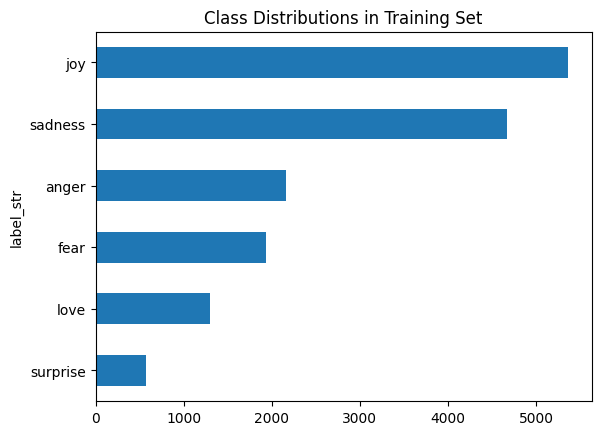

In [ ]:
df_train["label_str"].value_counts(ascending=True).plot.barh()
plt.title("Class Distributions in Training Set")
plt.show()

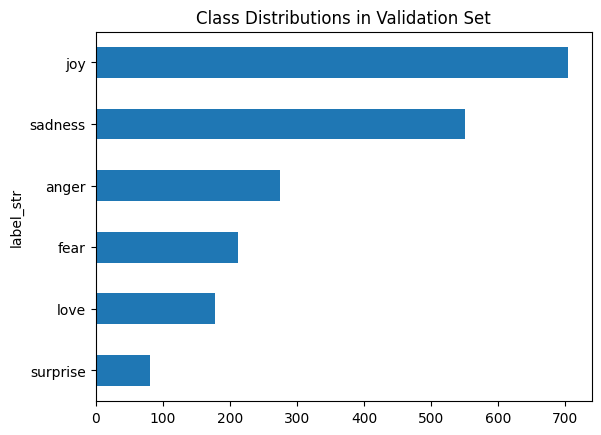

In [ ]:
plt.title("Class Distributions in Validation Set")
df_validation["label_str"].value_counts(ascending=True).plot.barh()
plt.show()

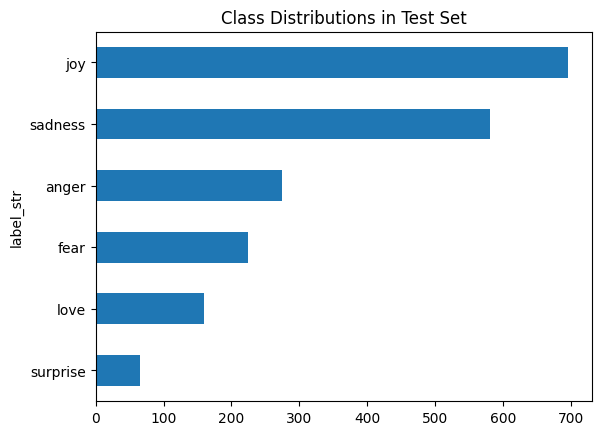

In [ ]:
plt.title("Class Distributions in Test Set")
df_test["label_str"].value_counts(ascending=True).plot.barh()
plt.show()

# Length of Tweets

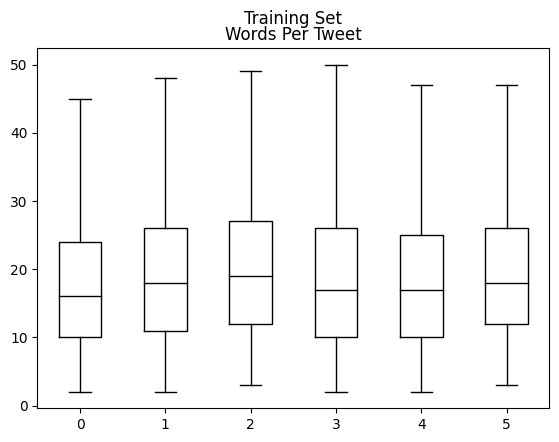

In [ ]:
df_train["Words Per Tweet"] = df_train["text"].str.split().apply(len)
df_train.boxplot("Words Per Tweet", by="label", grid=False,
 showfliers=False, color="black")
plt.suptitle("Training Set")
plt.xlabel("")
plt.show()
df_train.drop(columns=['Words Per Tweet'],inplace=True)

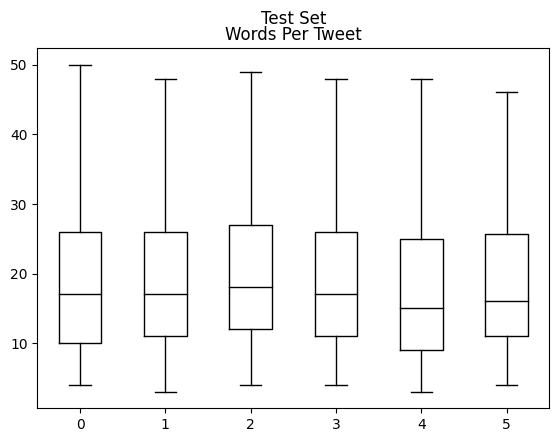

In [ ]:
df_test["Words Per Tweet"] = df_test["text"].str.split().apply(len)
df_test.boxplot("Words Per Tweet", by="label", grid=False,
 showfliers=False, color="black")
plt.suptitle("Test Set")
plt.xlabel("")
plt.show()
df_test.drop(columns=['Words Per Tweet'],inplace=True)

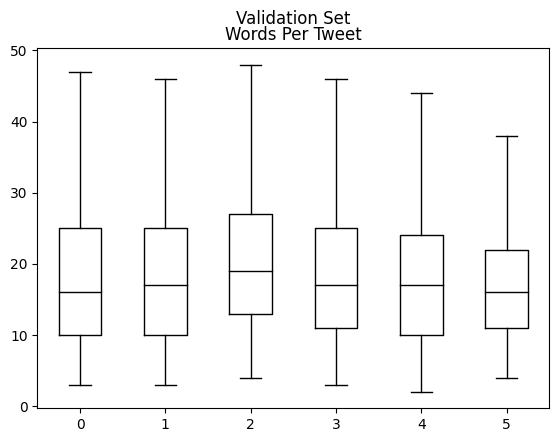

In [ ]:
df_validation["Words Per Tweet"] = df_validation["text"].str.split().apply(len)
df_validation.boxplot("Words Per Tweet", by="label", grid=False,
 showfliers=False, color="black")
plt.suptitle("Validation Set")
plt.xlabel("")
plt.show()
df_validation.drop(columns=['Words Per Tweet'],inplace=True)

# Tokenization Process

# Text to Tokens

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
encoded_text = tokenizer("The movie was not good")
print("encoded_text: ",encoded_text)
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(encoded_text,len(encoded_text.input_ids))
print(tokens)

encoded_text:  {'input_ids': [101, 1996, 3185, 2001, 2025, 2204, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
{'input_ids': [101, 1996, 3185, 2001, 2025, 2204, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]} 7
['[CLS]', 'the', 'movie', 'was', 'not', 'good', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] the movie was not good [SEP]


In [ ]:
print("tokenizer.vocab_size:",tokenizer.vocab_size)
print("Model max context length:",tokenizer.model_max_length)

tokenizer.vocab_size: 30522
Model max context length: 512


In [ ]:
text_raw = df_train['text'][2]
tokenized_text = tokenizer(text_raw) # raw text converted to index numbers
tokenized_text_tokens = tokenizer.convert_ids_to_tokens(tokenized_text.input_ids)
print("tokenized_text - indices: ",tokenized_text['input_ids'])
print("tokenized_text - attention mask: ",tokenized_text['attention_mask'])
print("tokenized_text_tokens: ",tokenized_text_tokens)

tokenized_text - indices:  [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102]
tokenized_text - attention mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
tokenized_text_tokens:  ['[CLS]', 'im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong', '[SEP]']


In [ ]:
df_input_ids = pd.DataFrame(tokenizer(list(df_train['text'][:3]))['input_ids'])
df_input_ids

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,101,1045,2134,2102,2514,26608,102,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,1045,2064,2175,2013,3110,2061,20625.0,2000.0,2061.0,...,2013.0,2108.0,2105.0,2619.0,2040.0,14977.0,1998.0,2003.0,8300.0,102.0
2,101,10047,9775,1037,3371,2000,2695,1045.0,2514.0,20505.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_attention_mask = pd.DataFrame(tokenizer(list(df_train['text'][:3]))['attention_mask'])
df_attention_mask

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1,1,1,1,1,1,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1,1,1,1,1,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1,1,1,1,1,1,1,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
df_train = Dataset.from_pandas(df_train)
df_test = Dataset.from_pandas(df_test)

In [ ]:
df_encoded_train = df_train.map(tokenize, batched=True, batch_size=None)
df_encoded_test = df_test.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
tokens2ids

[('[UNK]', 100), ('[SEP]', 102), ('[PAD]', 0), ('[CLS]', 101), ('[MASK]', 103)]

# Training the Text Classifier

## Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [ ]:
le = LabelEncoder()
le.fit(hf_dataset['train'].features['label'].names)

LabelEncoder()

In [ ]:
labels_int_list = list(np.unique(hf_dataset['train']['label']))
label_int2str = dict.fromkeys(labels_int_list)
label_int2str = {k:le.inverse_transform([k])[0] for k,v in label_int2str.items()}
label_int2str

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

def analyze_error_test_set(df_encoded_src):
    # Convert our dataset back to PyTorch tensors
    df_encoded_src.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    # Compute loss values
    df_encoded_src["validation"] = df_encoded_src["validation"].map(
        forward_pass_with_label, batched=True, batch_size=16)
    df_encoded_src.set_format("pandas")
    cols = ["text", "label", "predicted_label", "loss"]
    df_test = df_encoded_src["validation"][:][cols]
    df_test["predicted_label"] = df_test["predicted_label"]
    df_test["label"] = df_test["label"].apply(lambda x: label_int2str.get(x))
    df_test["predicted_label"] = df_test["predicted_label"].apply(lambda x: label_int2str.get(x))
    return df_test

## Training Methodology: BERT as Feature Extractor

### Load pretrained DistilBERT-Base-Uncased Model as Feature Extractor

In [ ]:
from transformers import AutoModel
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ",device)
model = AutoModel.from_pretrained(model_ckpt).to(device)

device:  cuda


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Extracting the last hidden states

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

def encode_dataset(df_source):
  df_encoded = df_source.map(tokenize, batched=True, batch_size=None)
  df_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
  return df_encoded

def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

def extract_hidden_states_df(df_source):
  df_encoded = encode_dataset(df_source)
  df_hidden = df_encoded.map(extract_hidden_states, batched=True)
  return df_hidden

In [ ]:
np.object = object
# It is imported to reset to huggingface dataset format when extracting features
hf_dataset.reset_format()
df_hidden = extract_hidden_states_df(hf_dataset)
df_hidden

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [ ]:
import numpy as np

X_train = np.array(df_hidden["train"]["hidden_state"])
X_valid = np.array(df_hidden["validation"]["hidden_state"])
X_test = np.array(df_hidden["test"]["hidden_state"])

y_train = np.array(df_hidden["train"]["label"])
y_valid = np.array(df_hidden["validation"]["label"])
y_test = np.array(df_hidden["test"]["label"])

X_train.shape, y_train.shape

((16000, 768), (16000,))

### Training Classifiers

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report)


from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import (StratifiedKFold, cross_val_score, GridSearchCV)

In [ ]:
# Train a Simple Classifier with Logistic Regression
clf_lr = LogisticRegression(max_iter=3000)
clf_lr.fit(X_train, y_train)
print("Test score:",clf_lr.score(X_test, y_test))

Test score: 0.627


In [ ]:
# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=3000),
}

# Metrics to evalaute hyperparam search
scoring = ['roc_auc_ovo', 'f1_micro']

# Define hyperparameters for tuning for each model
param_grid = {
    "LogisticRegression": {'C': [1.0, 5.0]},
    "XGBClassifier":{}
}

# Cross-Validation Method
cv_method = StratifiedKFold(n_splits=3,shuffle=True)

best_models = {}
best_scores = {}

# Hyperparameter tuning and model selection
for model_name, model in models.items():
    print(f"Performing GridSearchCV for {model_name}...")
    clf = GridSearchCV(
        model,
        param_grid[model_name],
        scoring=scoring,
        refit='f1_micro',
        cv=cv_method,
        verbose=1,
        n_jobs=-1)
    clf.fit(X_train, y_train)
    best_models[model_name] = clf.best_estimator_
    best_scores[model_name] = clf.best_score_

# Selecting the best model based on f1_macro score
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]

# Evaluation on the test set
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Print classification report on the test set
print(f"Classification report for {best_model_name}:")
print(classification_report(y_test, y_pred))

Performing GridSearchCV for LogisticRegression...
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Classification report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.64      0.72      0.68       581
           1       0.69      0.81      0.75       695
           2       0.40      0.24      0.30       159
           3       0.55      0.43      0.48       275
           4       0.54      0.48      0.51       224
           5       0.39      0.20      0.26        66

    accuracy                           0.63      2000
   macro avg       0.54      0.48      0.50      2000
weighted avg       0.61      0.63      0.61      2000



In [ ]:
best_scores

{'LogisticRegression': 0.6329376182186864}

### Training Methodology: Fine Tuning BERT

In [ ]:
# Create dataset
df_encoded = encode_dataset(hf_dataset)
df_encoded

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

def measure_model_performance(trainer, df_input, y_labels, labels_list):
    preds_output = trainer.predict(df_input)
    print(preds_output.metrics)
    y_preds = np.argmax(preds_output.predictions, axis=1)
    plot_confusion_matrix(y_preds, y_labels, labels_list)

In [ ]:
def train_model(model_ckpt, training_args, df_encoded_src, num_labels):
    # Create Model
    model = (AutoModelForSequenceClassification
            .from_pretrained(model_ckpt, num_labels=num_labels)
            .to(device))
    model_name = f"models/{model_ckpt}-finetuned-turkish-tweets"
    training_args.output_dir = model_name
    trainer = Trainer(model=model, args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=df_encoded_src["train"],
                    eval_dataset=df_encoded_src["validation"],
                    tokenizer=tokenizer)
    trainer.train()
    return trainer

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer
from transformers import Trainer

In [ ]:
# Set Batch Size
batch_size = 64
logging_steps = len(df_encoded['train']) // batch_size
num_train_epochs = 2
lr_initial = 2e-5
weight_decay = 1e-3
output_dir = ""
training_args = TrainingArguments(output_dir=output_dir,
                                num_train_epochs=num_train_epochs,
                                learning_rate=lr_initial,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                weight_decay=weight_decay,
                                evaluation_strategy="epoch",
                                disable_tqdm=False,
                                logging_steps=logging_steps,
                                push_to_hub=False,
                                log_level="error")

### Fine-Tuning for 'distilbert-base-uncased' model

In [ ]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
trainer = train_model(model_ckpt, training_args, df_encoded, num_labels=hf_dataset['train'].features['label'].num_classes)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.we

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.842100,0.326690,0.907500,0.905044
2,0.253000,0.222959,0.922500,0.922459


In [ ]:
labels_names_list = hf_dataset['train'].features['label'].names

{'test_loss': 0.22295910120010376, 'test_accuracy': 0.9225, 'test_f1': 0.9224593987272678, 'test_runtime': 4.1492, 'test_samples_per_second': 482.017, 'test_steps_per_second': 7.712}


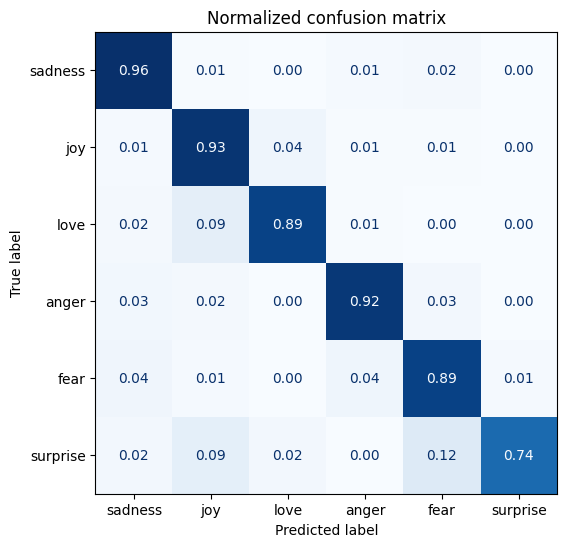

In [ ]:
measure_model_performance(trainer, df_encoded["validation"], df_encoded["validation"]['label'], labels_names_list)

{'test_loss': 0.217790886759758, 'test_accuracy': 0.9185, 'test_f1': 0.9178779177102621, 'test_runtime': 3.7283, 'test_samples_per_second': 536.438, 'test_steps_per_second': 8.583}


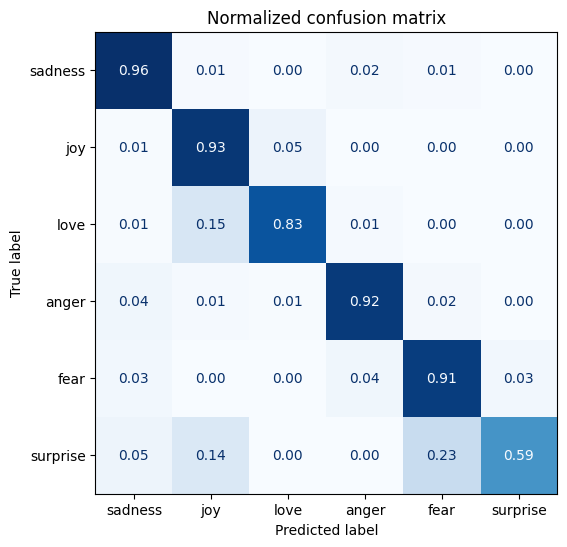

In [ ]:
measure_model_performance(trainer, df_encoded["test"], df_encoded["test"]['label'], labels_names_list)

### Error Analysis on Test Set

In [ ]:
model = trainer.model
df_test = analyze_error_test_set(df_encoded_src=df_encoded)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,anger,5.600072
882,i feel badly about reneging on my commitment t...,joy,anger,5.561788
465,i would eventually go in to these stores but i...,fear,sadness,5.434468
1963,i called myself pro life and voted for perry w...,fear,anger,5.227174
1274,i am going to several holiday parties and i ca...,fear,anger,5.224734
1111,im lazy my characters fall into categories of ...,fear,sadness,5.212109
1500,i guess we would naturally feel a sense of lon...,love,anger,5.122035
765,i feel super awkward and out of place right now,fear,anger,5.071721
1870,i guess i feel betrayed because i admired him ...,fear,anger,4.877157
1801,i feel that he was being overshadowed by the s...,joy,anger,4.779086


In [ ]:
df_test.sort_values("loss", ascending=False).iloc[0]['text']

'i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea'

In [ ]:
df_test.sort_values("loss", ascending=False).iloc[0][['label','predicted_label']]

label              surprise
predicted_label       anger
Name: 1950, dtype: object

In [ ]:
df_test.sort_values("loss", ascending=False).iloc[1]['text']

'i feel badly about reneging on my commitment to bring donuts to the faithful at holy family catholic church in columbus ohio'

In [ ]:
df_test.sort_values("loss", ascending=False).iloc[1][['label','predicted_label']]

label                joy
predicted_label    anger
Name: 882, dtype: object

In [ ]:
df_test.sort_values("loss", ascending=False).iloc[3]

text               i called myself pro life and voted for perry w...
label                                                           fear
predicted_label                                                anger
loss                                                        5.227174
Name: 1963, dtype: object

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
205,i cannot wait for school to end so i can chang...,fear,fear,0.015538
1020,i feel that the content i have in mind isnt re...,fear,fear,0.015838
908,i said earlier that the overall feeling is joy...,fear,fear,0.016121
1618,i had a good feeling about the presentation an...,fear,fear,0.016125
1263,i feel this way about blake lively,fear,fear,0.016184
752,i really do like the feeling of accomplishing ...,fear,fear,0.016210
1012,i definitely succumbed to pre holiday sales bu...,fear,fear,0.016321
941,i expected but it did feel hopeful and it defi...,fear,fear,0.016368
578,i got to christmas feeling positive about the ...,fear,fear,0.016374
611,i woke up this morning feeling hopeful and ene...,fear,fear,0.016424


In [ ]:
trainer.save_model("distil_bert_fine_tuned_emotions")

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification", model="distil_bert_fine_tuned_emotions")
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)
print(preds)

[[{'label': 'LABEL_0', 'score': 0.011856862343847752}, {'label': 'LABEL_1', 'score': 0.9444636702537537}, {'label': 'LABEL_2', 'score': 0.010744236409664154}, {'label': 'LABEL_3', 'score': 0.00957715604454279}, {'label': 'LABEL_4', 'score': 0.005727139301598072}, {'label': 'LABEL_5', 'score': 0.017630988731980324}]]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


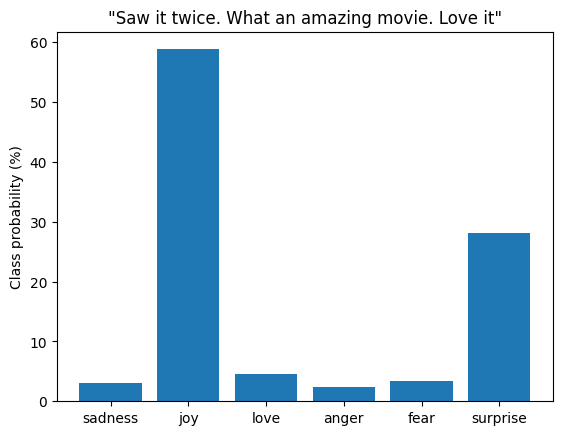

In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

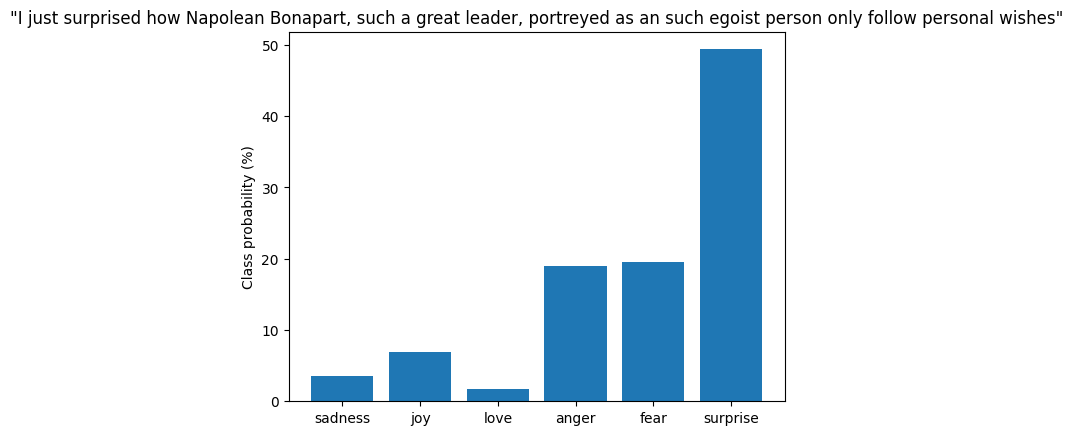

In [ ]:
custom_tweet = "I just surprised how Napolean Bonapart, such a great leader, portreyed as an such egoist person only follow personal wishes"
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

Unfortunately, this film appears to have been designed more to mock Napoleon than anything else. Reducing him to a pathetic caricature does a great disservice to a complex individual and makes this films value as a biopic close to nil. The battles scenes are the only reason I'm giving this even two stars.


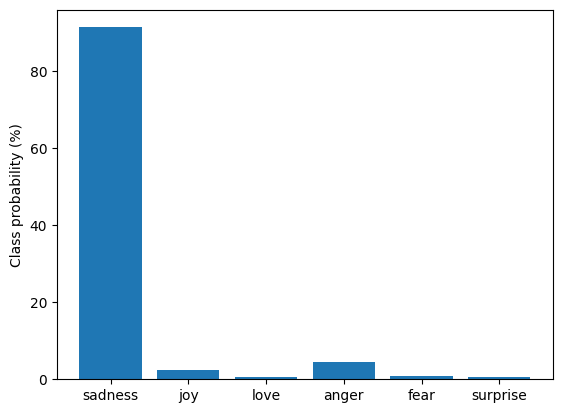

In [ ]:
custom_tweet = "Unfortunately, this film appears to have been designed more to mock Napoleon than anything else. Reducing him to a pathetic caricature does a great disservice to a complex individual and makes this films value as a biopic close to nil. The battles scenes are the only reason I'm giving this even two stars."
print(custom_tweet)

preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

Saw it twice. What an amazing movie. Love it


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


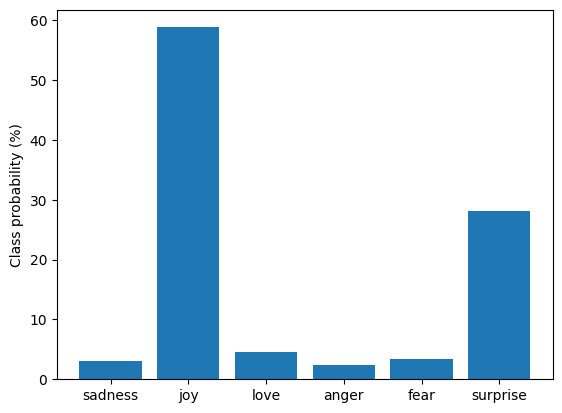

In [ ]:
custom_tweet = "Saw it twice. What an amazing movie. Love it"
print(custom_tweet)
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()

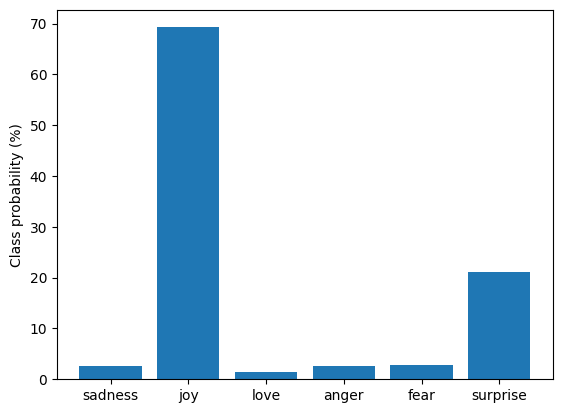

Visually stunning with some amazing battle scenes but it did have major pacing issues, especially in the first half. Also there was practically zero context given for like half the stuff that happened.


In [ ]:
custom_tweet = "Visually stunning with some amazing battle scenes but it did have major pacing issues, especially in the first half. Also there was practically zero context given for like half the stuff that happened."
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)

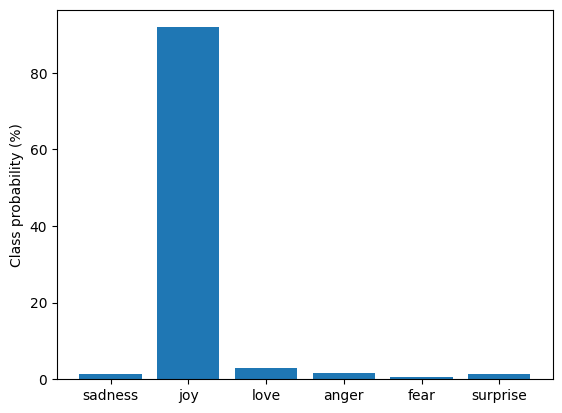

I am giving 2 stars out of 5


In [ ]:
custom_tweet = "I am giving 2 stars out of 5"
preds = classifier(custom_tweet, return_all_scores=True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels_names_list, 100 * preds_df["score"], color='C0')
plt.ylabel("Class probability (%)")
plt.show()
print(custom_tweet)

## Shap

In [ ]:
!pip install nlp
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.8 MB/s eta 0:00:00


In [ ]:
import nlp
import numpy as np
import scipy as sp
import torch
import transformers

import shap

In [ ]:
# define a prediction function
def f(x):
    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=512, truncation=True)
            for v in x
        ]
    ).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:, 1])  # use one vs rest logit units
    return val

In [ ]:
test = {'label': [5], 'text': [custom_tweet]}

In [ ]:
# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# explain the model's predictions on IMDB reviews
# imdb_train = nlp.load_dataset("imdb")["train"]
shap_values = explainer(test, fixed_context=1)

In [ ]:
# plot the first sentence's explanation
shap.plots.text(shap_values)